In [85]:
import numpy as np
import copy
import math
import time
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.animation as anim

# Initialization

This part contains all the the initializations that are common in all the codes. This makes sure that all the algorithms are using the same MDP for simulations. 

1. **transition_Action**: provides all the transition matrices with respect to every action.
2. **gamma**: discount factor
3. **stepsize**: we are using the same stepsize for all the algorithms.
4. **tau**: denotes the regularization parameter. If we set tau=0, then there is no regularization.

In [69]:
numStates = 70
numActions = 10

np.random.seed(1214)

transition_Action = np.random.rand(numActions, numStates,numStates)
for i in range(numActions):
    transition_Action[i] = transition_Action[i]/transition_Action[i].sum(axis=1)[:,None]
rewards = np.random.rand(numStates,numActions)

numIter_d = 1000
numIter_q = 1000
numIter_VI = 100
gamma = 0.5
# epsilon = 0.1
# numIter = 64*gamma*(numStates**2)*numActions
# numIter = int(numIter/((1-gamma)**6)*(epsilon**2))
numIter=100
print(numIter)
rho = (1/numStates)*np.ones(numStates)
stepsize = (1-gamma)**3
stepsize = stepsize/(2*gamma*numActions)



# stepsize = 0.1
tau = 0.0
print(stepsize)

100
0.0125


In [70]:
def project(r):
    n = r.size
    a = np.zeros(numActions)
    b = np.ones(numActions)
    total = np.sum(a)
    lambdas = np.append(a-r, b-r)
    idx = np.argsort(lambdas)
    lambdas = lambdas[idx]
    active = 1
    for i in range(1, 2*n):
        total += active*(lambdas[i] - lambdas[i-1])
        if total >= 1:
            lam = (1-total) / active + lambdas[i]
            return np.clip(r + lam, a, b)
        elif idx[i] < n:
            active += 1
        else:
            active -= 1
            
            
def cal_d_policy(policy):
    var_transition = sum(np.multiply(np.matmul(np.transpose([policy[a,:]]),np.ones((1,numStates))), 
                                 transition_Action[a])  for a in range(numActions))
    var_d_policy = np.identity(numStates)
    for iter_d in range(numIter_d):
        var_d_policy = np.identity(numStates) + gamma*np.matmul(var_transition,var_d_policy)
    var_d_policy = (1-gamma)*var_d_policy
    return var_d_policy
    
def cal_q_function(var_q_function,policy):
    Iter_q =0
    q = var_q_function
    while Iter_q < numIter_q:
        Iter_q += 1
        for state in range(numStates):
            for action in range(numActions):
                q[state,action] = rewards[state,action]+gamma*sum(np.multiply(transition_Action[action,state,:],
                    sum(np.multiply(q[:,a],np.transpose(policy[a,:])) for a in range(numActions))))
        if Iter_q%(numIter_q/2) ==0 and np.count_nonzero(q==0)!=0:
            Iter_q =0
    return q
            
def cal_v_function(var_v_function,policy):
    v = var_v_function
    var_transition = sum(np.multiply(np.matmul(np.transpose([policy[a,:]]),np.ones((1,numStates))), 
                                 transition_Action[a])  for a in range(numActions))
    for iter_v in range(numIter_q):
        v = sum(np.multiply(rewards[:,a],policy[a,:]) for a in range(numActions)) + gamma*sum(
           var_transition[:,s]*v[s] for s in range(numStates))
    return v

# Value Iteration

This part calculates the optimal value function and the corresponding policy using the Bellman operator for the optimal value function. 

In [71]:
v_function_star = np.zeros(numStates)
while 1:
    previous_v_function_star = v_function_star
    v_function_star = np.amax(rewards + gamma*sum( 
        v_function_star[s]*np.transpose(transition_Action[:,:,s])  for s in range(numStates)),axis = 1)
    np.amax(previous_v_function_star - v_function_star)
    if np.amax(abs(previous_v_function_star -v_function_star)) < 0.00000001:
        break
# print(v_function_star)
best_policy=np.argmax(rewards + gamma*sum( 
        v_function_star[s]*np.transpose(transition_Action[:,:,s])  for s in range(numStates)),axis = 1)

policy = np.zeros((numStates,numActions))
for state in range(numStates):
    policy[state,best_policy[state]] =1

policy = np.transpose(policy)
# print(policy)

In [72]:
q_function = np.zeros((numStates,numActions))
q_function = cal_q_function(q_function,policy)
delta_value = -1000
for state in range(numStates):
    for action in range(numActions):
        var_delta = q_function[state,action] - v_function_star[state]
        if var_delta != 0:
            delta_value = max(var_delta,delta_value)
print(delta_value)

6.813963171481419e-09


# Policy Gradient
### Tabular method (Direct Parameterization)

In this method, gradient is taken directly with respect to the policy. [Alekh-Agarwal] paper provides the gradient for the value function in case of direct parameteriztion. That paper also provides the details regarding the convergence of the algorithm. As given in the paper, the rate of convergence of the algorithm is 1/\sqrt(t).

Here is the description of the terms used in the code below
1. **policy** : denotes the current policy. 
3. **d_policy**: denotes the frequency of each state with respect to the policy for each initial state
4. **d_policy_rho**: denotes the frequency of each state when the initial state has distribution rho.
5. **q_function**: denotes the q-function for the current policy
6. **v_function**: denotes the value-function for the current policy. 
7. **error**: denotes the L1 difference between the optimal value function and the current value function.
8. **gradient**: denotes the calculated gradient

In [18]:
np.random.seed(1234)
theta = np.random.rand(numActions,numStates)
policy = np.exp(theta)
policy = policy/policy.sum(axis=0)[None,:]
v_function = np.zeros(numStates)

start_time = time.time()
error_vector = [1 for r in range(numIter)]
q_function = np.zeros((numStates,numActions))

for iter in range(numIter):
    
    d_policy = cal_d_policy(policy)
    d_policy_rho = np.matmul(rho,d_policy)
    q_function = cal_q_function(q_function,policy)
    v_function = cal_v_function(v_function,policy)
    
    error = abs(sum(v_function_star[s]-v_function[s] for s in range(numStates)))/(numStates)
    error_vector[iter] = error
#     print(error)
    
    gradient = np.transpose(np.multiply(np.matmul(np.transpose([d_policy_rho]),np.ones((1,numActions))),q_function))
    gradient = 1/(1-gamma)*gradient
    update = policy + stepsize*gradient
    update = np.transpose(update)
    for state in range(numStates):
        policy[:,state] = np.transpose(project(update[state]))

print(time.time()-start_time)
# print(policy)

2748.6050102710724


# NPG - constant stepsize

The policy update for this algorithm again comes from the same paper. 

In [19]:
np.random.seed(1234)
theta = np.random.rand(numActions,numStates)
policy = np.exp(theta)
policy = policy/policy.sum(axis=0)[None,:]
v_function = np.zeros(numStates)
start_time = time.time()
min_error = 500
error_vector_npg = [1 for r in range(numIter)]
q_function = np.zeros((numStates,numActions))

for iter in range(numIter):
    
    d_policy = cal_d_policy(policy)
    d_policy_rho = np.matmul(rho,d_policy)
    q_function = cal_q_function(q_function,policy)
    v_function = cal_v_function(v_function,policy)
#     L = -math.log(gamma)
    L = math.log(numActions)
    error = abs(sum(v_function_star[s]-v_function[s] for s in range(numStates)))/(numStates)            
    error_vector_npg[iter] = error
    
    policy = np.multiply(np.transpose(policy),np.exp(L*q_function))
    policy = np.transpose(policy)
    policy = policy/policy.sum(axis=0)[None,:] 
    
print(time.time()-start_time)
print(policy)

2724.320804834366
[[5.96018890e-43 9.09012331e-68 9.97525704e-01 8.32456172e-65
  1.91653803e-51 9.99999649e-01 1.78186184e-63 3.25527122e-62
  1.97513480e-09 3.25911019e-93 9.99998124e-01 4.11843997e-83
  2.24794340e-11 6.12045704e-62 3.75398988e-62 5.55038453e-22
  1.24260335e-04 1.02464605e-81 3.58280677e-28 1.03546464e-66
  4.00274969e-59 1.31226730e-64 1.00000000e+00 2.36299807e-74
  1.24811584e-70 1.08816746e-43 3.97761202e-25 7.31122966e-52
  1.61344766e-70 3.94564160e-60 5.75226828e-05 1.00000000e+00
  2.35280952e-14 1.14380533e-84 1.00000000e+00 9.65307429e-86
  3.65649530e-42 5.99549957e-86 1.52400586e-61 1.04407507e-83
  3.60630940e-84 2.78902076e-39 3.08422974e-52 3.11978105e-96
  7.33611057e-54 5.40024098e-85 4.16531296e-19 3.18541930e-10
  6.43045535e-75 3.39686271e-68 1.76073427e-54 3.30836766e-50
  2.95741792e-29 1.36087207e-32 2.83831501e-53 9.65370122e-09
  5.82582265e-19 6.43499499e-46 2.41524380e-52 5.87416298e-70
  9.93384686e-01 9.13526167e-01 1.53610717e-06 9.937

# NPG - Increasing stepsize

The policy update for this algorithm again comes from the same paper. 

In [20]:
np.random.seed(1234)
theta = np.random.rand(numActions,numStates)
policy = np.exp(theta)
policy = policy/policy.sum(axis=0)[None,:]
v_function = np.zeros(numStates)
start_time = time.time()
min_error = 500
error_vector_npg_incStep = [1 for r in range(numIter)]
q_function = np.zeros((numStates,numActions))

for iter in range(numIter):
    
    d_policy = cal_d_policy(policy)
    d_policy_rho = np.matmul(rho,d_policy)
    q_function = cal_q_function(q_function,policy)
    v_function = cal_v_function(v_function,policy)
    L = -math.log(gamma)
    error = abs(sum(v_function_star[s]-v_function[s] for s in range(numStates)))/(numStates)            
    error_vector_npg_incStep[iter] = error
    
    policy = np.multiply(np.transpose(policy),np.exp((L*iter)*q_function))
    policy = np.transpose(policy)
    policy = policy/policy.sum(axis=0)[None,:] 
    
print(time.time()-start_time)
# print(policy)

3039.541708946228


# NPG - Adaptive stepsize

In [46]:
np.random.seed(1234)
theta = np.random.rand(numActions,numStates)
policy = np.exp(theta)
policy = policy/policy.sum(axis=0)[None,:]
v_function = np.zeros(numStates)
start_time = time.time()
min_error = 500
error_vector_adaptive = [0 for r in range(numIter)]
q_function = np.zeros((numStates,numActions))

delta = np.zeros(numStates)

for iter in range(numIter):
    
    d_policy = cal_d_policy(policy)
    d_policy_rho = np.matmul(rho,d_policy)
    q_function = cal_q_function(q_function,policy)
    v_function = cal_v_function(v_function,policy)
    
    error = abs(sum(v_function_star[s]-v_function[s] for s in range(numStates)))/(numStates)            
    error_vector_adaptive[iter] = error
    
    if error< 0.000001:
        break
    
    second_best_var =  np.matmul(np.transpose([np.max(q_function,axis =1)]),np.ones((1,numActions))) - q_function
    delta = np.zeros(numStates)
    for state_var in range(numStates):
        delta[state_var] = np.min(second_best_var[state_var][np.nonzero(second_best_var[state_var])])
    L = -math.log(gamma)
    adaptive_step = L*iter
    adaptive_step_var = 0
    for state_var in range(numStates):
        for action_var in range(numActions):
            if q_function[state_var,action_var] == np.max(q_function,axis =1)[state_var] and delta[state_var]!=0:
                adaptive_step_var = (L*iter + math.log(1/policy[action_var,state_var]) )/delta[state_var]
            adaptive_step = max(adaptive_step,(1-gamma)*adaptive_step_var)
    adaptive_step = min(adaptive_step, L*iter + 100)
    
    policy = np.multiply(np.transpose(policy),np.exp(adaptive_step*q_function))
    policy = np.transpose(policy)
    policy = policy/policy.sum(axis=0)[None,:] 
    
print(time.time()-start_time)
print(policy)

1181.396950006485
[[0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
  1.24387571e-175 0.00000000e+000 1.00000000e+000 0.00000000e+000
  3.15269409e-209 0.00000000e+000 0.00000000e+000 0.00000000e+000
  2.37911059e-081 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 3.53355185e-084 1.00000000e+000
  1.35436559e-266 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 4.18586744e-191
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 1.08120789e-164
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.000000

# NPG Adaptive non-increasing

In [47]:
np.random.seed(1234)
theta = np.random.rand(numActions,numStates)
policy = np.exp(theta)
policy = policy/policy.sum(axis=0)[None,:]
v_function = np.zeros(numStates)
start_time = time.time()
min_error = 500
error_vector_non_ad = [0 for r in range(numIter)]
q_function = np.zeros((numStates,numActions))

delta = np.zeros(numStates)

for iter in range(numIter):
    
    d_policy = cal_d_policy(policy)
    d_policy_rho = np.matmul(rho,d_policy)
    q_function = cal_q_function(q_function,policy)
    v_function = cal_v_function(v_function,policy)
    
    error = abs(sum(v_function_star[s]-v_function[s] for s in range(numStates)))/(numStates)            
    error_vector_non_ad[iter] = error
    
    if error< 0.000001:
        break
    
    second_best_var =  np.matmul(np.transpose([np.max(q_function,axis =1)]),np.ones((1,numActions))) - q_function
    delta = np.zeros(numStates)
    for state_var in range(numStates):
        delta[state_var] = np.min(second_best_var[state_var][np.nonzero(second_best_var[state_var])])
    L = -math.log(gamma)
    adaptive_step = L*iter
    for state_var in range(numStates):
        for action_var in range(numActions):
            if q_function[state_var,action_var] == np.max(q_function,axis =1)[state_var] and delta[state_var]!=0:
                adaptive_step_var = (L + math.log(1/policy[action_var,state_var]) )/delta[state_var]
            adaptive_step = max(adaptive_step,(1-gamma)*adaptive_step_var)
    adaptive_step = min(adaptive_step, L + 100)
    
    policy = np.multiply(np.transpose(policy),np.exp(adaptive_step*q_function))
    policy = np.transpose(policy)
    policy = policy/policy.sum(axis=0)[None,:] 
    
print(time.time()-start_time)
print(policy)

1290.7915132045746
[[0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
  2.87917613e-175 0.00000000e+000 1.00000000e+000 0.00000000e+000
  8.50894986e-209 0.00000000e+000 0.00000000e+000 0.00000000e+000
  3.50240143e-081 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 5.24862103e-084 1.00000000e+000
  4.86922952e-266 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 1.04291480e-190
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 2.39081222e-164
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000

# Policy Iteration

In [23]:
np.random.seed(1234)
theta = np.random.rand(numActions,numStates)
policy = np.exp(theta)
policy = policy/policy.sum(axis=0)[None,:]
v_function = np.zeros(numStates)
start_time = time.time()
min_error = 500
error_vector_PI = [1 for r in range(numIter)]
q_function = np.zeros((numStates,numActions))

for iter in range(numIter):
    
    d_policy = cal_d_policy(policy)
    d_policy_rho = np.matmul(rho,d_policy)
    q_function = cal_q_function(q_function,policy)
    v_function = cal_v_function(v_function,policy)
    
    error = abs(sum(v_function_star[s]-v_function[s] for s in range(numStates)))/(numStates)            
    error_vector_PI[iter] = error
    
    policy = np.zeros((numActions,numStates))
    
    for state_var in range(numStates):
        for action_var in range(numActions):
            if q_function[state_var,action_var] == np.max(q_function,axis =1)[state_var]:
                policy[action_var,state_var] = 1
    policy = policy/policy.sum(axis=0)[None,:] 
    
print(time.time()-start_time)
print(policy)

3726.2845730781555
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0

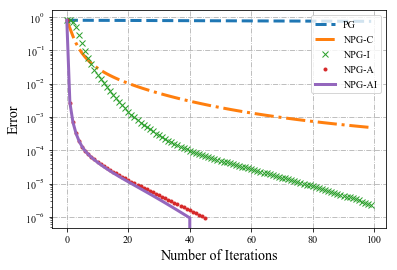

In [87]:
x = range(numIter)
plt.rcParams.update({'font.size': 10})
# plt.rcParams["font.family"] = "serif"
# plt.rcParams.update({'font.serif': "Times new Roman"})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.plot(x,error_vector,"--",label='PG',linewidth=3.0)
plt.plot(x,error_vector_npg,"-.",label='NPG-C',linewidth=3.0)
plt.plot(x,error_vector_npg_incStep,"x",label='NPG-I',linewidth=3.0)
plt.plot(x,error_vector_non_ad,".",label='NPG-A',linewidth=3.0)
plt.plot(x,error_vector_adaptive,label='NPG-AI',linewidth=3.0)
plt.legend()
# plt.xlim(0,10)
plt.grid(ls = '-.')
plt.yscale('log')
plt.xlabel("Number of Iterations",fontsize =14)
plt.ylabel("Error",fontsize =14)
plt.savefig("cdcfig.eps")

In [92]:
# print(error_vector_adaptive)
# print(error_vector_npg)
print(error_vector_PI)

[0.8678526657040995, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.713566177059723e-09, 6.71356617705

In [37]:
print(error_vector_non_ad)
print(error_vector_adaptive)

[0.7985299972083376, 0.002667674529433417, 0.0006910565020367101, 0.0003206244010027749, 0.00018777068327868106, 0.0001271184565836541, 9.479186045707268e-05, 7.502766128398365e-05, 6.148928936924313e-05, 5.143679369798664e-05, 4.3585741699784086e-05, 3.726802487642138e-05, 3.209140269981552e-05, 2.7797787400496433e-05, 2.4202353070561828e-05, 2.1165839751275632e-05, 1.8580613052240505e-05, 1.6362573124939495e-05, 1.4445735987833608e-05, 1.2778221102863593e-05, 1.131912839123585e-05, 1.0036069683061477e-05, 8.903221370539147e-06, 7.899802233984106e-06, 7.008896920915727e-06, 6.216556594768846e-06, 5.511118224304263e-06, 4.882693575493567e-06, 4.3227879564535144e-06, 3.824016815674141e-06, 3.3798952122600565e-06, 2.9846809398088275e-06, 2.6332567503014763e-06, 2.321040820540965e-06, 2.0439174782417776e-06, 1.7981823955879963e-06, 1.5804981096894416e-06, 1.3878569465632295e-06, 1.217549314204623e-06, 1.0671359693903427e-06, 9.344233093479457e-07, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,